# Predicting Stock Price Direction Using Decision Trees and Technical Indicators

This notebook demonstrates how to predict the daily direction of stock prices using a Decision Tree classifier. Leveraging historical data from multiple stocks, it incorporates technical indicators such as moving averages, returns, momentum, volatility, and RSI to build a feature-rich dataset. The model aims to classify whether the stock price will rise or fall the next trading day, providing insights into the effectiveness of Decision Trees in financial time series classification.

## Import Libraries

!pip install yfinance pandas numpy scikit-learn seaborn matplotlib

In [1]:
import yfinance as yf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

plt.style.use('dark_background')

## Data

### Download Data

In [2]:
# Step 1: Download and prepare data
data = yf.download("GOOGL", start="2010-01-01", end="2023-12-31", auto_adjust=True, interval="1wk")
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,
2010-01-01,14.796626,15.678547,14.760513,15.614787,613541844
2010-01-08,14.690775,15.054651,14.293525,14.744322,1099986912
2010-01-15,14.519671,14.783176,14.252431,14.777696,771611616
2010-01-22,13.307000,14.211335,13.215097,14.059409,909861228
2010-01-29,13.119958,13.501517,13.089572,13.411607,673897428


### Select Relevant Columns

In [3]:
# If the data contains a multi-level column index, select the first level (to drop the 'Ticker' row)
data.columns = data.columns.get_level_values(0)

# Keep only the columns you're interested in
data = data[['Open', 'Close', 'Volume', 'Low', 'High']]

# Now the data is simplified and ready for analysis
data.head()

Price,Open,Close,Volume,Low,High
Date,,,,,
2010-01-01,15.614787,14.796626,613541844,14.760513,15.678547
2010-01-08,14.744322,14.690775,1099986912,14.293525,15.054651
2010-01-15,14.777696,14.519671,771611616,14.252431,14.783176
2010-01-22,14.059409,13.307000,909861228,13.215097,14.211335
2010-01-29,13.411607,13.119958,673897428,13.089572,13.501517


### Visualize Stock's Closing Price

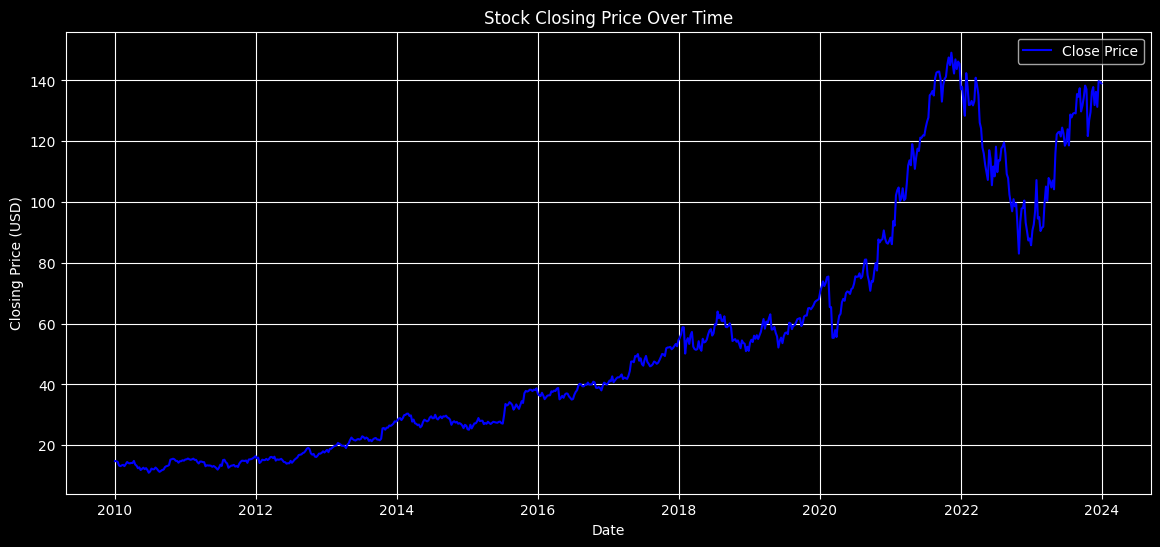

In [4]:
# Plotting the closing price
plt.figure(figsize=(14,6))
plt.plot(data.index, data['Close'], label='Close Price', color='blue')
plt.title('Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.savefig('stock_closing_price.png')
plt.show()

### Label Price Movement Direction

In [5]:
# Step 2: Label - 1 if tomorrow's close > today's close
data["Direction"] = (data["Close"].shift(-1) > data["Close"]).astype(int)

# Drop the last row as it has no label
data.dropna(inplace=True)

data.head()

Price,Open,Close,Volume,Low,High,Direction
Date,,,,,,
2010-01-01,15.614787,14.796626,613541844,14.760513,15.678547,0
2010-01-08,14.744322,14.690775,1099986912,14.293525,15.054651,0
2010-01-15,14.777696,14.519671,771611616,14.252431,14.783176,0
2010-01-22,14.059409,13.307000,909861228,13.215097,14.211335,0
2010-01-29,13.411607,13.119958,673897428,13.089572,13.501517,1


## Feature Engineering: Calculating Technical Indicators

This cell creates new features to capture important market behaviors and trends. It includes daily and 5-day returns, moving averages (MA), volatility, momentum, Relative Strength Index (RSI), and price range features. These indicators help improve model performance by reflecting momentum, trend strength, volatility, and price action.

In [6]:
data['Return_1d'] = data['Close'].pct_change()
data['Return_5d'] = data['Close'].pct_change(5)

data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_10'] = data['Close'].rolling(window=10).mean()
data['MA_ratio'] = data['MA_5'] / data['MA_10']  # Short/long trend

data['Volatility_5d'] = data['Close'].rolling(window=5).std()

data['Momentum_10'] = data['Close'] - data['Close'].shift(10)

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['RSI_14'] = compute_rsi(data['Close'])

data['Range'] = data['High'] - data['Low']
data['Close_to_High'] = data['High'] - data['Close']
data['Close_to_Low'] = data['Close'] - data['Low']

In [7]:
feature_cols = [
    'Open', 'Close', 'Volume', 'Low', 'High',
    'Return_1d', 'Return_5d',
    'MA_5', 'MA_10', 'MA_ratio',
    'Volatility_5d',
    'Momentum_10',
    'RSI_14',
    'Range', 'Close_to_High', 'Close_to_Low'
]

# Drop rows with NaNs from rolling features
data.dropna(inplace=True)

X = data[feature_cols]
y = data["Direction"]

## Feature Scaling and Train-Test Split

In [8]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

## Train Decision Tree Model

In [9]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

## Model Prediction and Evaluation

In [10]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.25      0.32        68
           1       0.51      0.71      0.60        76

    accuracy                           0.49       144
   macro avg       0.48      0.48      0.46       144
weighted avg       0.48      0.49      0.46       144



## Visualizing Predictions vs. Actual Close Price

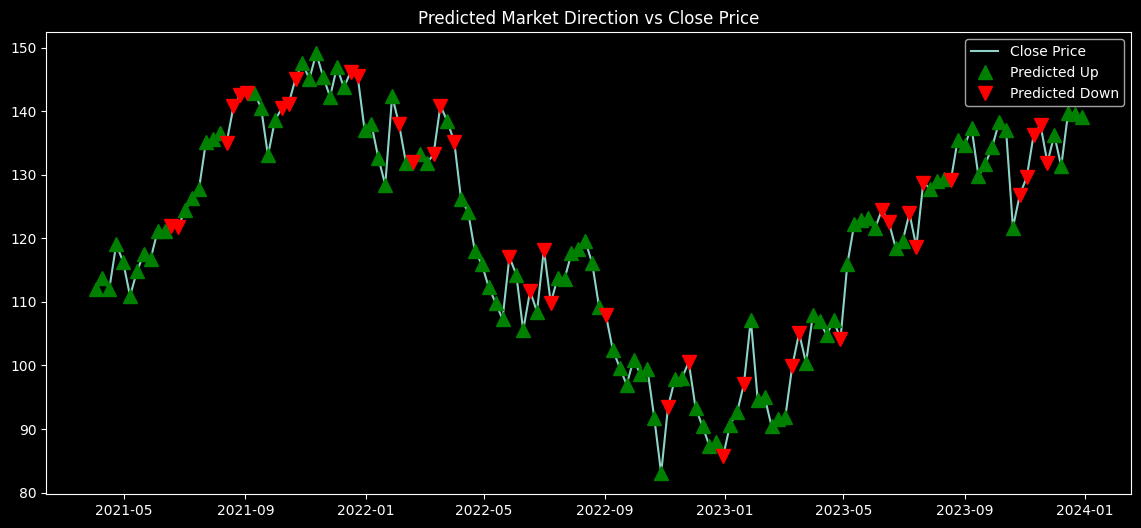

In [11]:
plt.figure(figsize=(14,6))
plt.plot(data.index[-len(y_test):], data["Close"][-len(y_test):], label='Close Price')
plt.plot(data.index[-len(y_test):][y_pred == 1], 
         data["Close"][-len(y_test):][y_pred == 1], 
         '^', markersize=10, color='g', label='Predicted Up')
plt.plot(data.index[-len(y_test):][y_pred == 0], 
         data["Close"][-len(y_test):][y_pred == 0], 
         'v', markersize=10, color='r', label='Predicted Down')
plt.title("Predicted Market Direction vs Close Price")
plt.legend()
plt.savefig('predicted_market_direction.png')
plt.show()

## Visualize the Confusion Matrix

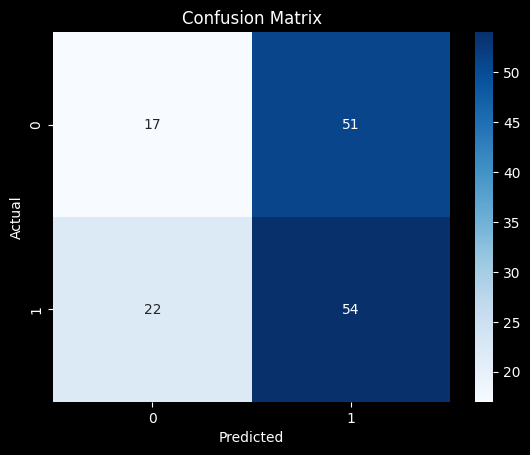

In [12]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

## Visualizing Feature Importances

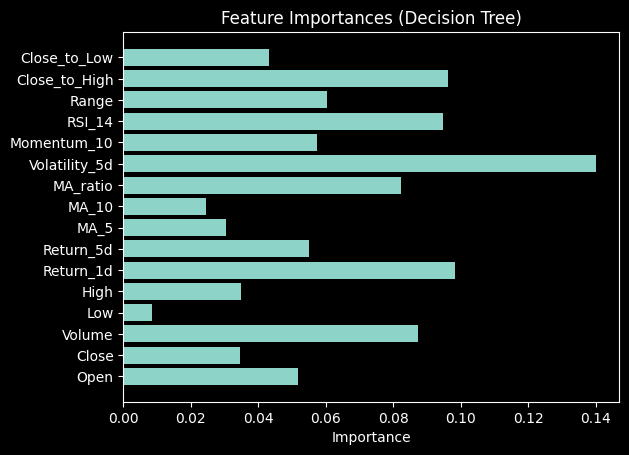

In [13]:
importances = model.feature_importances_
feat_names = X.columns

plt.barh(feat_names, importances)
plt.title("Feature Importances (Decision Tree)")
plt.xlabel("Importance")
plt.savefig('feature_importances.png')
plt.show()